In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from sklearn import preprocessing, metrics

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [12]:
sales = pd.read_csv('../data/sales_train_validation.csv')

sell = pd.read_csv('../data/sell_prices.csv')

cal = pd.read_csv('../data/calendar.csv')

disasters = pd.read_csv('../data/us_disasters_m5.csv')

### Calendar


date: The date in a “y-m-d” format.

wm_yr_wk: The id of the week the date belongs to.

weekday: The type of the day (Saturday, Sunday, ..., Friday).

wday: The id of the weekday, starting from Saturday.

month: The month of the date.

year: The year of the date.

event_name_1: If the date includes an event, the name of this event.

event_type_1: If the date includes an event, the type of this event.

event_name_2: If the date includes a second event, the name of this event.

event_type_2: If the date includes a second event, the type of this event.

snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP 3 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

In [4]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [6]:
cal.iloc[1]

date            2011-01-30
wm_yr_wk             11101
weekday             Sunday
wday                     2
month                    1
year                  2011
d                      d_2
event_name_1           NaN
event_type_1           NaN
event_name_2           NaN
event_type_2           NaN
snap_CA                  0
snap_TX                  0
snap_WI                  0
Name: 1, dtype: object

In [7]:
# Check for null values
absolute = cal.isnull().sum().sort_values(ascending=False)
percentage = (cal.isnull().sum()/len(cal)*100).sort_values(ascending=False)
pd.concat([absolute, percentage], keys=['total count','percentage of null values'], axis=1)

,total count,percentage of null values
event_name_2,1964,99.746064
event_type_2,1964,99.746064
event_name_1,1807,91.772473
event_type_1,1807,91.772473
date,0,0.000000
wm_yr_wk,0,0.000000
weekday,0,0.000000
wday,0,0.000000
month,0,0.000000
year,0,0.000000


In [8]:
date_range = (cal['date'].min(), cal['date'].max())
print(f"Date range: {date_range[0]} to {date_range[1]}")

Date range: 2011-01-29 to 2016-06-19


In [9]:
event_types_1 = cal[['event_name_1', 'event_type_1']].dropna(how='all').drop_duplicates()
print(event_types_1)

            event_name_1 event_type_1
8              SuperBowl     Sporting
16         ValentinesDay     Cultural
23         PresidentsDay     National
39             LentStart    Religious
46             LentWeek2    Religious
47         StPatricksDay     Cultural
50             Purim End    Religious
85        OrthodoxEaster    Religious
87            Pesach End    Religious
96         Cinco De Mayo     Cultural
99          Mother's day     Cultural
121          MemorialDay     National
122       NBAFinalsStart     Sporting
134         NBAFinalsEnd     Sporting
141         Father's day     Cultural
156      IndependenceDay     National
184       Ramadan starts    Religious
214          Eid al-Fitr    Religious
219             LaborDay     National
254          ColumbusDay     National
275            Halloween     Cultural
282            EidAlAdha    Religious
286          VeteransDay     National
299         Thanksgiving     National
330            Christmas     National
333         

In [10]:
event_types_2 = cal[['event_name_2', 'event_type_2']].dropna(how='all').drop_duplicates()
print(event_types_2)

        event_name_2 event_type_2
85            Easter     Cultural
827    Cinco De Mayo     Cultural
1177  OrthodoxEaster    Religious
1233    Father's day     Cultural


In [11]:
# Combine event types from cal dataframe
combined_events = cal[['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].copy()

# Combine event names and types
combined_events['event_name'] = combined_events['event_name_1'].combine_first(combined_events['event_name_2'])
combined_events['event_type'] = combined_events['event_type_1'].combine_first(combined_events['event_type_2'])

# Drop duplicates and reset index
combined_events = combined_events[['event_name', 'event_type']].drop_duplicates().reset_index(drop=True)
combined_events.dropna(inplace=True)
print(combined_events)

             event_name event_type
1             SuperBowl   Sporting
2         ValentinesDay   Cultural
3         PresidentsDay   National
4             LentStart  Religious
5             LentWeek2  Religious
6         StPatricksDay   Cultural
7             Purim End  Religious
8        OrthodoxEaster  Religious
9            Pesach End  Religious
10        Cinco De Mayo   Cultural
11         Mother's day   Cultural
12          MemorialDay   National
13       NBAFinalsStart   Sporting
14         NBAFinalsEnd   Sporting
15         Father's day   Cultural
16      IndependenceDay   National
17       Ramadan starts  Religious
18          Eid al-Fitr  Religious
19             LaborDay   National
20          ColumbusDay   National
21            Halloween   Cultural
22            EidAlAdha  Religious
23          VeteransDay   National
24         Thanksgiving   National
25            Christmas   National
26         Chanukah End  Religious
27              NewYear   National
28    OrthodoxChrist

In [12]:
combined_events['event_type'].value_counts()

event_type
National     10
Religious    10
Cultural      7
Sporting      3
Name: count, dtype: int64

In [13]:
# Count how many days have two events
two_events_days = cal.dropna(subset=['event_name_1', 'event_name_2']).shape[0]
print(f"Number of days with two events: {two_events_days}")
# Count the number of different events
num_events = combined_events['event_name'].nunique()
print(f"Number of different events: {num_events}")

# Count the number of different event types
num_event_types = combined_events['event_type'].nunique()
print(f"Number of different event types: {num_event_types}")

# Count the number of different kinds of events in each type
events_per_type = combined_events.groupby('event_type')['event_name'].nunique()
print("Number of different kinds of events in each type:")
print(events_per_type)

Number of days with two events: 5
Number of different events: 30
Number of different event types: 4
Number of different kinds of events in each type:
event_type
Cultural      7
National     10
Religious    10
Sporting      3
Name: event_name, dtype: int64


The U.S. federal government provides a nutritional assistance benefit called the Supplemental Nutrition Assistance Program (SNAP). SNAP provides low-income families and individuals with an electronic benefits transfer debit card to purchase food.

SNAP, or the Supplemental Nutrition Assistance Program, is a federal program in the United States that helps low-income individuals and families afford nutritious food. Previously known as food stamps, SNAP provides benefits through an Electronic Benefits Transfer (EBT) card, which works like a debit card to purchase food at participating stores.

The goal of SNAP is to alleviate hunger and improve the well-being of eligible households. To qualify, individuals must meet certain income and resource guidelines. The amount of assistance provided is based on the household's size, income, and expenses, such as rent and utilities.

SNAP benefits are meant to supplement a person's food budget, not cover all their food expenses. The program is managed by the U.S. Department of Agriculture (USDA) and administered by state agencies.

In [14]:
snap_totals = cal[['snap_CA', 'snap_TX', 'snap_WI']].sum()
print(snap_totals)

snap_CA    650
snap_TX    650
snap_WI    650
dtype: int64


### Sales

Contains the historical daily unit sales data per product and store [d_1 - d_1913].

item_id: The id of the product.

dept_id: The id of the department the product belongs to.

cat_id: The id of the category the product belongs to.

store_id: The id of the store where the product is sold.

state_id: The State where the store is located. d_1, d_2, ..., d_i, ... d_1941: The number of units sold at day i, starting from 2011-01-29.

In [15]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [16]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [17]:
# Check for null values
absolute = sales.isnull().sum().sort_values(ascending=False)
percentage = (sales.isnull().sum()/len(sales)*100).sort_values(ascending=False)
pd.concat([absolute, percentage], keys=['total count','percentage of null values'], axis=1)

,total count,percentage of null values
id,0,0.0
d_1270,0,0.0
d_1282,0,0.0
d_1281,0,0.0
d_1280,0,0.0
...,...,...
d_630,0,0.0
d_629,0,0.0
d_628,0,0.0
d_627,0,0.0


In [18]:
num_cat_id = sales['cat_id'].unique()
print(f"Different cat_id: {num_cat_id}")

Different cat_id: ['HOBBIES' 'HOUSEHOLD' 'FOODS']


In [19]:
item_id = sales['item_id'].nunique()
print(f"Number of different item_id: {item_id}")

Number of different item_id: 3049


In [20]:
dept_id = sales['dept_id'].unique()
print(f"Number of different dept_id: {dept_id}")

Number of different dept_id: ['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']


In [21]:
store_id = sales['store_id'].unique()
print(f"Different store_id: {store_id}")

Different store_id: ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


state_id
CA    12196
TX     9147
WI     9147
Name: count, dtype: int64


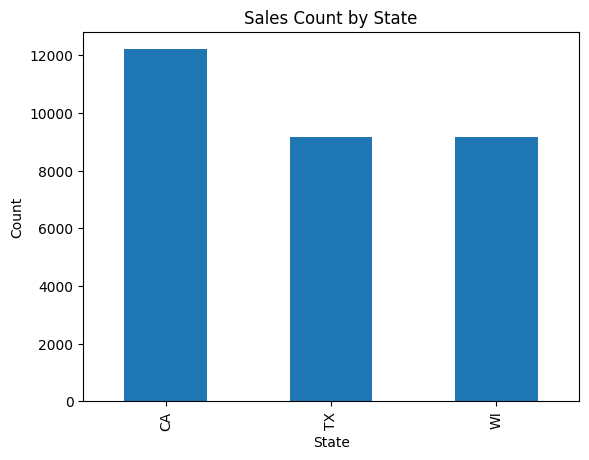

In [22]:
state_counts = sales['state_id'].value_counts()
print(state_counts)
state_counts.plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Sales Count by State')
plt.show()

In [23]:
# Calculate the total sales for each row and add it as a new column
sales['total_sales'] = sales.iloc[:, 6:].sum(axis=1)

In [24]:
# Calculate the total sales of each state based on the sum of each day
daily_sales_by_state = sales.groupby('state_id').sum().drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id'])
daily_sales_by_state_sum = daily_sales_by_state.sum(axis=1)
print(daily_sales_by_state_sum)

state_id
CA    57351094
TX    37798012
WI    36241712
dtype: int64


In [25]:
# Calculate the total sales of each state based on the sum of each day
daily_sales_by_store = sales.groupby('store_id').sum().drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'state_id'])
daily_sales_by_store_sum = daily_sales_by_store.sum(axis=1)
print(daily_sales_by_store_sum)

store_id
CA_1    15396432
CA_2    11370950
CA_3    22376360
CA_4     8207352
TX_1    11190584
TX_2    14428768
TX_3    12178660
WI_1    10298124
WI_2    13088024
WI_3    12855564
dtype: int64


In [26]:
highest_sales_store_id = daily_sales_by_store_sum.idxmax()

print(f"The store with the highest sales is: {highest_sales_store_id}")

The store with the highest sales is: CA_3


In [27]:
# Calculate the total sales of each cat based on the sum of each day
daily_sales_by_cat = sales.groupby('cat_id').sum().drop(columns=['id', 'item_id', 'dept_id', 'state_id', 'store_id'])
daily_sales_by_cat_sum = daily_sales_by_cat.sum(axis=1)
print(daily_sales_by_cat_sum)

cat_id
FOODS        90179878
HOBBIES      12249600
HOUSEHOLD    28961340
dtype: int64


In [28]:
# Group by state_id and cat_id, then sum the total sales
sales.groupby(['state_id', 'cat_id']).agg({'total_sales':'sum'}).groupby(level=0).apply(lambda x: x / float(x.sum())).unstack()

total_sales                    
cat_id                  FOODS   HOBBIES HOUSEHOLD
state_id state_id                                
CA       CA          0.669431  0.106010  0.224559
TX       TX          0.685561  0.084255  0.230184
WI       WI          0.713941  0.082368  0.203691

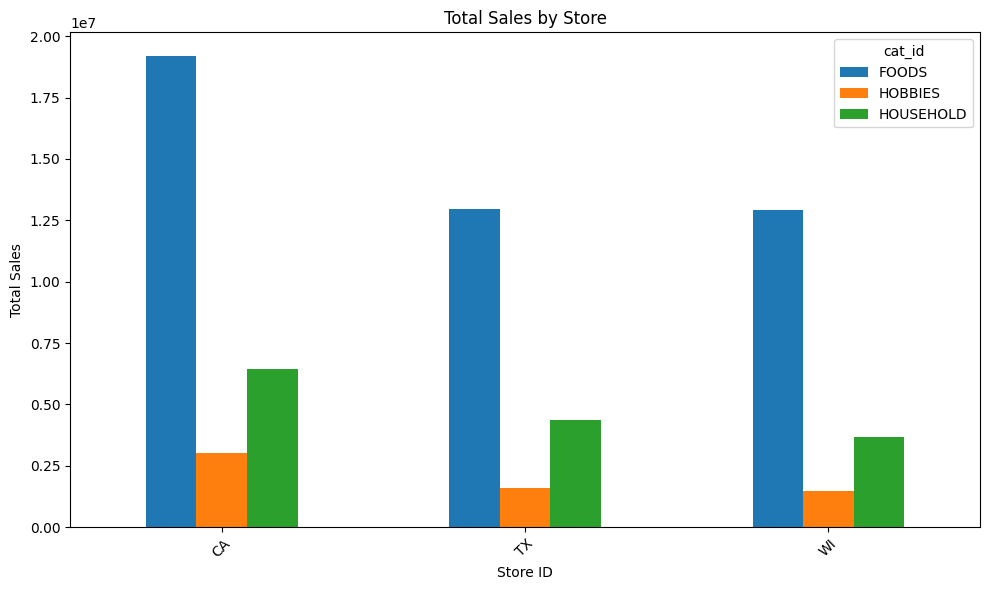

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'sales' is your DataFrame
sales_grouped = sales.groupby(['state_id', 'cat_id'], as_index=False)['total_sales'].sum()

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# Using pivot to reshape the data for easier plotting
pivot_data = sales_grouped.pivot(index='state_id', columns='cat_id', values='total_sales')

# Plotting bar chart
pivot_data.plot(kind='bar', ax=ax)

ax.set_title('Total Sales by Store')
ax.set_ylabel('Total Sales')
ax.set_xlabel('Store ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
# Calculate the total sales of each cat based on the sum of each day
daily_sales_by_dept = sales.groupby('dept_id').sum().drop(columns=['id', 'item_id', 'cat_id', 'state_id', 'store_id'])
daily_sales_by_dept_sum = daily_sales_by_dept.sum(axis=1)
print(daily_sales_by_dept_sum)

dept_id
FOODS_1        10176082
FOODS_2        15259644
FOODS_3        64744152
HOBBIES_1      11192920
HOBBIES_2       1056680
HOUSEHOLD_1    23001052
HOUSEHOLD_2     5960288
dtype: int64


In [31]:
# Group by state_id and cat_id, then sum the total sales
sales.groupby(['store_id', 'dept_id']).agg({'total_sales':'sum'}).groupby(level=0).apply(lambda x:  x / float(x.sum())).unstack()

total_sales                                          \
dept_id               FOODS_1   FOODS_2   FOODS_3 HOBBIES_1 HOBBIES_2   
store_id store_id                                                       
CA_1     CA_1        0.073764  0.114980  0.510227  0.106716  0.007165   
CA_2     CA_2        0.126232  0.058521  0.427379  0.101712  0.010469   
CA_3     CA_3        0.065861  0.107485  0.498415  0.079148  0.006742   
CA_4     CA_4        0.083713  0.130935  0.472401  0.132042  0.005507   
TX_1     TX_1        0.065351  0.112865  0.497032  0.068991  0.007696   
TX_2     TX_2        0.070486  0.108320  0.516350  0.077716  0.010441   
TX_3     TX_3        0.067571  0.123851  0.492247  0.075537  0.011051   
WI_1     WI_1        0.098407  0.116680  0.452676  0.118104  0.009239   
WI_2     WI_2        0.081136  0.166968  0.480530  0.050197  0.006376   
WI_3     WI_3        0.062047  0.126249  0.547678  0.066275  0.006327   

                                           
dept_id           HOUSEHOLD_1 HOUSEHOLD_2  
store_id store_id                          
CA_1     CA_1        0.142912    0.044237  
CA_2     CA_2        0.194681    0.081007  
CA_3     CA_3        0.191905    0.050443  
CA_4     CA_4        0.129378    0.046025  
TX_1     TX_1        0.204786    0.043280  
TX_2     TX_2        0.173850    0.042837  
TX_3     TX_3        0.190536    0.039207  
WI_1     WI_1        0.159811    0.045084  
WI_2     WI_2        0.185623    0.029171  
WI_3     WI_3        0.158317    0.033108

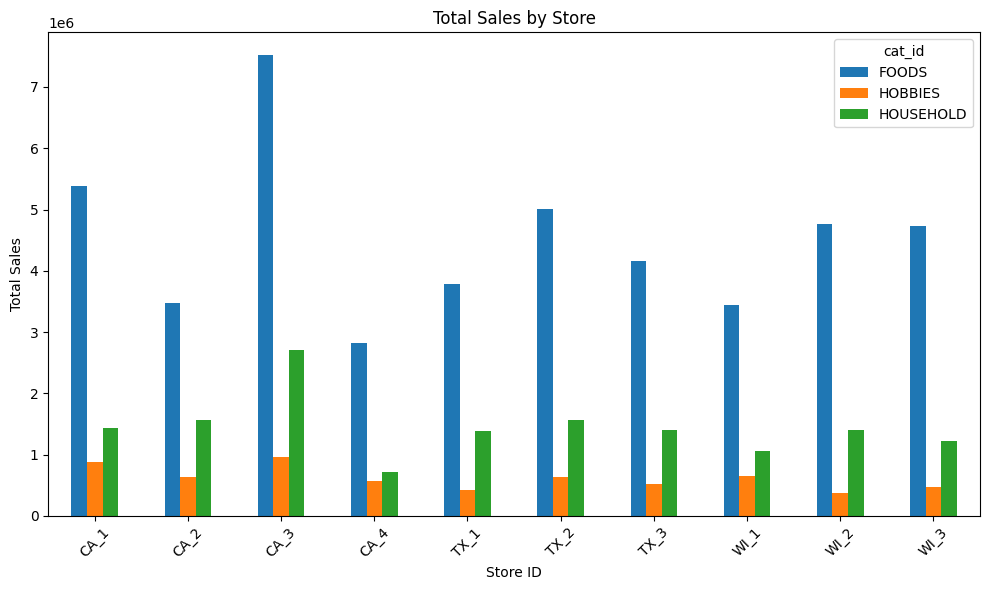

In [32]:
# Assuming 'sales' is your DataFrame
sales_grouped = sales.groupby(['store_id', 'cat_id'], as_index=False)['total_sales'].sum()

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# Using pivot to reshape the data for easier plotting
pivot_data = sales_grouped.pivot(index='store_id', columns='cat_id', values='total_sales')

# Plotting bar chart
pivot_data.plot(kind='bar', ax=ax)

ax.set_title('Total Sales by Store')
ax.set_ylabel('Total Sales')
ax.set_xlabel('Store ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
# Group by state_id and dept_id, then sum the total sales
sales_by_dept_state = sales.groupby(['store_id', 'dept_id']).agg({'total_sales':'sum'})

# Find the department with the most sales for each state
max_sales_by_dept_state = sales_by_dept_state.groupby(level=0).idxmax()

# Extract the department with the most sales for each state
max_sales_by_dept_state = max_sales_by_dept_state['total_sales'].apply(lambda x: x[1])

# Print the results
for state, dept in max_sales_by_dept_state.items():
    print(f"The department with the most sales in {state} is: {dept}")

The department with the most sales in CA_1 is: FOODS_3
The department with the most sales in CA_2 is: FOODS_3
The department with the most sales in CA_3 is: FOODS_3
The department with the most sales in CA_4 is: FOODS_3
The department with the most sales in TX_1 is: FOODS_3
The department with the most sales in TX_2 is: FOODS_3
The department with the most sales in TX_3 is: FOODS_3
The department with the most sales in WI_1 is: FOODS_3
The department with the most sales in WI_2 is: FOODS_3
The department with the most sales in WI_3 is: FOODS_3


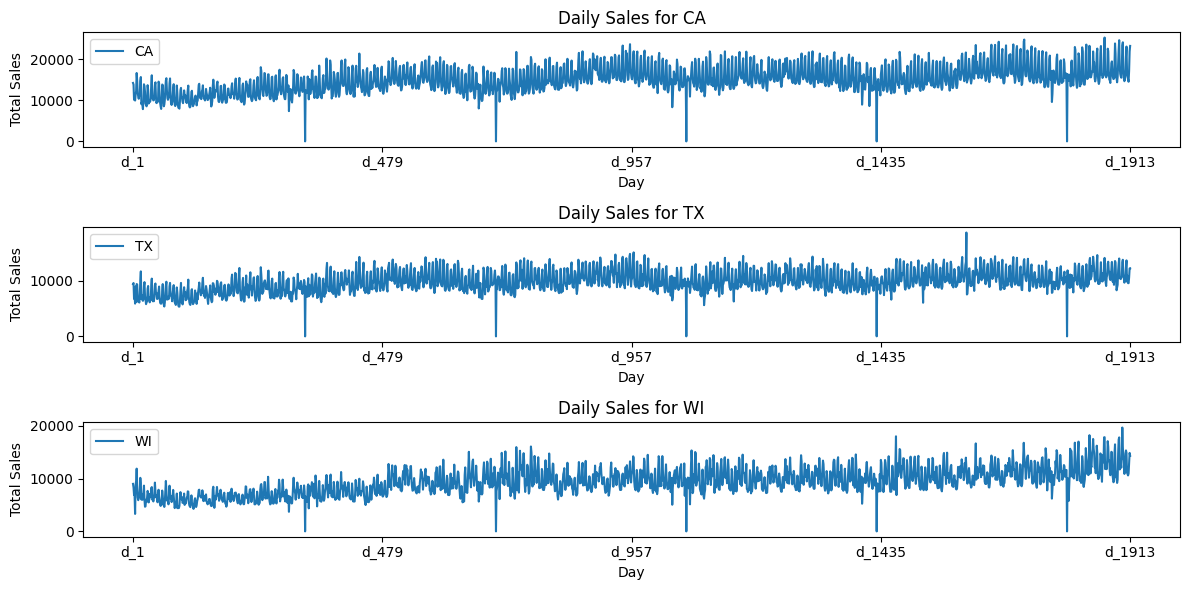

In [34]:
# Plotting the time series data
fig, ax = plt.subplots(figsize=(12, 6))
# Set x-ticks to show only 5 values
x_ticks = np.linspace(0, len(daily_sales_by_state.columns[:-1]) - 1, 5, dtype=int)
x_labels = [daily_sales_by_state.columns[i] for i in x_ticks]

# Create a subplot for each state
for i, state in enumerate(daily_sales_by_state.index):
    ax = plt.subplot(3, 1, i + 1)
    ax.plot(daily_sales_by_state.columns[:-1], daily_sales_by_state.loc[state, daily_sales_by_state.columns[:-1]], label=state)
    ax.set_xticks(x_labels)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Day')
    ax.set_ylabel('Total Sales')
    ax.set_title(f'Daily Sales for {state}')
    ax.legend()
plt.tight_layout()
plt.show()


### Sell price

In [35]:
sell.head()


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [36]:
# Check for null values
absolute = sell.isnull().sum().sort_values(ascending=False)
percentage = (sell.isnull().sum()/len(sell)*100).sort_values(ascending=False)
pd.concat([absolute, percentage], keys=['total count','percentage of null values'], axis=1)

,total count,percentage of null values
store_id,0,0.0
item_id,0,0.0
wm_yr_wk,0,0.0
sell_price,0,0.0


In [37]:
# Group by item_id and calculate the min and max of wm_yr_wk for each item
wm_yr_wk_range = sell.groupby('item_id')['wm_yr_wk'].agg(['min', 'max']).reset_index()

# Rename the columns for clarity
wm_yr_wk_range.columns = ['item_id', 'wm_yr_wk_min', 'wm_yr_wk_max']

# Display the DataFrame
print(wm_yr_wk_range)

              item_id  wm_yr_wk_min  wm_yr_wk_max
0         FOODS_1_001         11101         11621
1         FOODS_1_002         11101         11621
2         FOODS_1_003         11101         11621
3         FOODS_1_004         11206         11621
4         FOODS_1_005         11101         11621
...               ...           ...           ...
3044  HOUSEHOLD_2_512         11101         11621
3045  HOUSEHOLD_2_513         11308         11621
3046  HOUSEHOLD_2_514         11101         11621
3047  HOUSEHOLD_2_515         11349         11621
3048  HOUSEHOLD_2_516         11101         11621

[3049 rows x 3 columns]


In [38]:
# Group by item_id and calculate the size of wm_yr_wk for each item
wm_yr_wk_range = sell.groupby('item_id')['wm_yr_wk'].size().reset_index(name='wm_yr_wk_count')

# Display the DataFrame
print(wm_yr_wk_range)

              item_id  wm_yr_wk_count
0         FOODS_1_001            2819
1         FOODS_1_002            2819
2         FOODS_1_003            2820
3         FOODS_1_004            2250
4         FOODS_1_005            2817
...               ...             ...
3044  HOUSEHOLD_2_512            2814
3045  HOUSEHOLD_2_513            1683
3046  HOUSEHOLD_2_514            2817
3047  HOUSEHOLD_2_515            1285
3048  HOUSEHOLD_2_516            2810

[3049 rows x 2 columns]


In [39]:
# Group by item_id and calculate the size of wm_yr_wk for each item
wm_yr_wk_range = sell.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min', 'max']).reset_index()

# Display the DataFrame
print(wm_yr_wk_range)

      store_id          item_id    min    max
0         CA_1      FOODS_1_001  11101  11621
1         CA_1      FOODS_1_002  11101  11621
2         CA_1      FOODS_1_003  11101  11621
3         CA_1      FOODS_1_004  11206  11621
4         CA_1      FOODS_1_005  11101  11621
...        ...              ...    ...    ...
30485     WI_3  HOUSEHOLD_2_512  11101  11621
30486     WI_3  HOUSEHOLD_2_513  11311  11621
30487     WI_3  HOUSEHOLD_2_514  11101  11621
30488     WI_3  HOUSEHOLD_2_515  11352  11621
30489     WI_3  HOUSEHOLD_2_516  11101  11621

[30490 rows x 4 columns]


In [40]:
# Group by item_id and calculate the size of wm_yr_wk for each item
wm_yr_wk_range = sell.groupby(['store_id','item_id'])['wm_yr_wk'].size().reset_index(name='wm_yr_wk_count')

# Display the DataFrame
print(wm_yr_wk_range)

      store_id          item_id  wm_yr_wk_count
0         CA_1      FOODS_1_001             282
1         CA_1      FOODS_1_002             282
2         CA_1      FOODS_1_003             282
3         CA_1      FOODS_1_004             225
4         CA_1      FOODS_1_005             282
...        ...              ...             ...
30485     WI_3  HOUSEHOLD_2_512             282
30486     WI_3  HOUSEHOLD_2_513             168
30487     WI_3  HOUSEHOLD_2_514             282
30488     WI_3  HOUSEHOLD_2_515             127
30489     WI_3  HOUSEHOLD_2_516             282

[30490 rows x 3 columns]


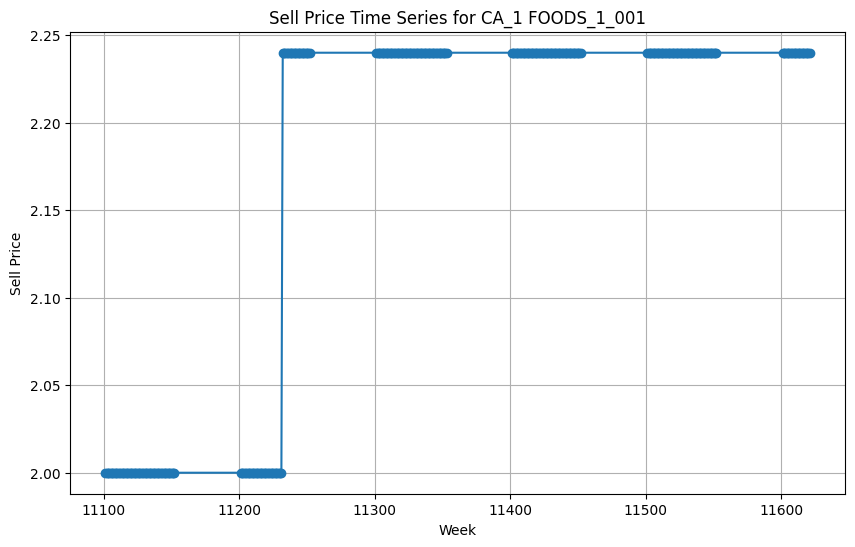

Number of data points: 282


In [41]:
# Filter the data for CA_1 FOODS_1_001
filtered_data = sell[(sell['store_id'] == 'CA_1') & (sell['item_id'] == 'FOODS_1_001')]

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['wm_yr_wk'], filtered_data['sell_price'], marker='o')
plt.title('Sell Price Time Series for CA_1 FOODS_1_001')
plt.xlabel('Week')
plt.ylabel('Sell Price')
plt.grid(True)
plt.show()

# Print the number of data points
num_data_points = len(filtered_data)
print(f"Number of data points: {num_data_points}")

For the sell data, we cna see that, each item has different start selling time and different time range. Although the begin and end time are same, the len of each time range are different, which may mean that there is break of some products.

from the plot we can see that there is no data in some weeks but based on the previous and behind weeks I think we can fill the nan by the same value...

In [42]:
# Group by store_id and calculate the min and max of wm_yr_wk for each item
wm_yr_wk_range = sell.groupby('store_id')['wm_yr_wk'].agg(['min', 'max']).reset_index()

# Rename the columns for clarity
wm_yr_wk_range.columns = ['store_id', 'wm_yr_wk_min', 'wm_yr_wk_max']

# Display the DataFrame
print(wm_yr_wk_range)

  store_id  wm_yr_wk_min  wm_yr_wk_max
0     CA_1         11101         11621
1     CA_2         11101         11621
2     CA_3         11101         11621
3     CA_4         11101         11621
4     TX_1         11101         11621
5     TX_2         11101         11621
6     TX_3         11101         11621
7     WI_1         11101         11621
8     WI_2         11101         11621
9     WI_3         11101         11621


In [43]:
# Group by item_id and calculate the size of wm_yr_wk for each item
sell_price_range = sell.groupby(['store_id','item_id'])[['wm_yr_wk','sell_price']].agg(['min', 'max']).reset_index()
sell_price_range['wm_yr_wk_count'] = sell.groupby(['store_id', 'item_id'])['wm_yr_wk'].size().values
# Display the DataFrame
print(sell_price_range)

      store_id          item_id wm_yr_wk        sell_price         \
                                     min    max        min    max   
0         CA_1      FOODS_1_001    11101  11621       2.00   2.24   
1         CA_1      FOODS_1_002    11101  11621       7.88   9.48   
2         CA_1      FOODS_1_003    11101  11621       2.88   3.23   
3         CA_1      FOODS_1_004    11206  11621       1.50   1.96   
4         CA_1      FOODS_1_005    11101  11621       2.94   3.54   
...        ...              ...      ...    ...        ...    ...   
30485     WI_3  HOUSEHOLD_2_512    11101  11621       3.97   3.97   
30486     WI_3  HOUSEHOLD_2_513    11311  11621       2.78   2.78   
30487     WI_3  HOUSEHOLD_2_514    11101  11621      17.94  19.54   
30488     WI_3  HOUSEHOLD_2_515    11352  11621       1.97   1.97   
30489     WI_3  HOUSEHOLD_2_516    11101  11621       5.94   5.94   

      wm_yr_wk_count  
                      
0                282  
1                282  
2         

In [44]:
sell_price_range[sell_price_range["item_id"] == "HOUSEHOLD_2_514"]

store_id          item_id wm_yr_wk        sell_price         \
                                     min    max        min    max   
3046      CA_1  HOUSEHOLD_2_514    11101  11621      17.94  19.54   
6095      CA_2  HOUSEHOLD_2_514    11101  11621      17.94  19.54   
9144      CA_3  HOUSEHOLD_2_514    11101  11621      15.00  19.54   
12193     CA_4  HOUSEHOLD_2_514    11101  11621      15.84  19.54   
15242     TX_1  HOUSEHOLD_2_514    11102  11621      15.00  19.54   
18291     TX_2  HOUSEHOLD_2_514    11101  11621       1.00  19.54   
21340     TX_3  HOUSEHOLD_2_514    11101  11621      12.99  19.54   
24389     WI_1  HOUSEHOLD_2_514    11101  11621      15.94  19.54   
27438     WI_2  HOUSEHOLD_2_514    11103  11621      17.94  20.97   
30487     WI_3  HOUSEHOLD_2_514    11101  11621      17.94  19.54   

      wm_yr_wk_count  
                      
3046             282  
6095             282  
9144             282  
12193            282  
15242            281  
18291            282  
21340            282  
24389            282  
27438            280  
30487            282

### Disasters

disaster_number: Sequentially assigned number used to designate an event or incident declared as a disaster.

state: One of the three states "CA", "TX", or "WI".

declaration_type: One of "DR" (= major disaster), "EM" (= emergency management), or "FM" (= "fire management")

declaration_date: Date the disaster was declared.

incident_type: Type of incident such as "Fire", "Flood", or "Biological". The incident type will affect the types of assistance available.

declaration_title: Title for the disaster.

ih_program_declared: Binary flag indicating whether the "Individuals and Households program" was declared for this disaster.

ia_program_declared: Binary flag indicating whether the "Individual Assistance program" was declared for this disaster.

pa_program_declared: Binary flag indicating whether the "Public Assistance program" was declared for this disaster.

hm_program_declared: Binary flag indicating whether the "Hazard Mitigation program" was declared for this disaster.

incident_begin_date: Date the incident itself began.

incident_end_date: Date the incident itself ended. The M5 constraint is that the disaster must have begun before the start of the evaluation time period on 2016-05-23 and ended on or after the begin of the training data range on 2011-01-29. This feature has about 14% NA entries, which were considered under the assumption that start data = end date.

fips: 5-digit FIPS county code; used to identify counties and county equivalents in the United States, the District of Columbia, US territories, outlying areas of the US and freely associated states. Concatenated from the 2 source columns "fipsStateCode" and "fipsCountyCode".

designated_area: The name or phrase describing the U.S. county that was included in the declaration.

In [45]:
disasters.head(20)    

,disaster_number,state,declaration_type,declaration_date,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,fips,designated_area
0,2862,TX,FM,2011-02-28T03:12:00Z,Fire,Willow Creek South Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,NaN,48375,Potter (County)
1,2863,TX,FM,2011-02-28T03:25:00Z,Fire,Matador Fire,0,0,1,0,2011-02-27T05:00:00Z,NaN,48345,Motley (County)
2,2864,TX,FM,2011-02-28T03:37:00Z,Fire,Tanglewood Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,NaN,48381,Randall (County)
3,2865,TX,FM,2011-02-28T05:55:00Z,Fire,Mitchell Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,NaN,48335,Mitchell (County)
4,2867,TX,FM,2011-03-12T00:32:00Z,Fire,Enmin Fire,0,0,1,0,2011-03-11T05:00:00Z,2011-03-17T04:00:00Z,48237,Jack (County)
5,2870,TX,FM,2011-03-12T06:19:00Z,Fire,Big Trickle Ranch Fire,0,0,1,0,2011-03-11T05:00:00Z,2011-03-17T04:00:00Z,48035,Bosque (County)
6,2870,TX,FM,2011-03-12T06:19:00Z,Fire,Big Trickle Ranch Fire,0,0,1,0,2011-03-11T05:00:00Z,2011-03-17T04:00:00Z,48425,Somervell (County)
7,2881,TX,FM,2011-04-04T02:39:00Z,Fire,Bates Field Fire,0,0,1,0,2011-04-03T04:00:00Z,2011-04-06T04:00:00Z,48329,Midland (County)
8,2881,TX,FM,2011-04-04T02:39:00Z,Fire,Bates Field Fire,0,0,1,0,2011-04-03T04:00:00Z,2011-04-06T04:00:00Z,48135,Ector (County)
9,2882,TX,FM,2011-04-05T06:18:00Z,Fire,El Cenizo Fire,0,0,1,0,2011-04-04T04:00:00Z,2011-04-08T04:00:00Z,48479,Webb (County)


In [46]:
disasters['designated_area'] = disasters['designated_area'].str.replace(r'\s*\(County\)', '', regex=True)
print(disasters['designated_area'])

0            Potter
1            Motley
2           Randall
3          Mitchell
4              Jack
           ...     
622    Throckmorton
623            Hall
624            Leon
625         Bastrop
626        Brazoria
Name: designated_area, Length: 627, dtype: object


In [47]:
# Check for null values
absolute = disasters.isnull().sum().sort_values(ascending=False)
percentage = (disasters.isnull().sum()/len(disasters)*100).sort_values(ascending=False)
pd.concat([absolute, percentage], keys=['total count','percentage of null values'], axis=1)

,total count,percentage of null values
incident_end_date,11,1.754386
disaster_number,0,0.000000
state,0,0.000000
declaration_type,0,0.000000
declaration_date,0,0.000000
incident_type,0,0.000000
declaration_title,0,0.000000
ih_program_declared,0,0.000000
ia_program_declared,0,0.000000
pa_program_declared,0,0.000000


In [48]:
disasters['incident_end_date'] = disasters['incident_end_date'].fillna(disasters['declaration_date'])
print(disasters['incident_end_date'])

0      2011-02-28T03:12:00Z
1      2011-02-28T03:25:00Z
2      2011-02-28T03:37:00Z
3      2011-02-28T05:55:00Z
4      2011-03-17T04:00:00Z
               ...         
622    2016-06-25T03:59:00Z
623    2016-06-25T03:59:00Z
624    2016-06-25T03:59:00Z
625    2016-06-25T03:59:00Z
626    2016-06-25T03:59:00Z
Name: incident_end_date, Length: 627, dtype: object


In [49]:
disasters.head(20)    

,disaster_number,state,declaration_type,declaration_date,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,fips,designated_area
0,2862,TX,FM,2011-02-28T03:12:00Z,Fire,Willow Creek South Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,2011-02-28T03:12:00Z,48375,Potter
1,2863,TX,FM,2011-02-28T03:25:00Z,Fire,Matador Fire,0,0,1,0,2011-02-27T05:00:00Z,2011-02-28T03:25:00Z,48345,Motley
2,2864,TX,FM,2011-02-28T03:37:00Z,Fire,Tanglewood Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,2011-02-28T03:37:00Z,48381,Randall
3,2865,TX,FM,2011-02-28T05:55:00Z,Fire,Mitchell Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,2011-02-28T05:55:00Z,48335,Mitchell
4,2867,TX,FM,2011-03-12T00:32:00Z,Fire,Enmin Fire,0,0,1,0,2011-03-11T05:00:00Z,2011-03-17T04:00:00Z,48237,Jack
5,2870,TX,FM,2011-03-12T06:19:00Z,Fire,Big Trickle Ranch Fire,0,0,1,0,2011-03-11T05:00:00Z,2011-03-17T04:00:00Z,48035,Bosque
6,2870,TX,FM,2011-03-12T06:19:00Z,Fire,Big Trickle Ranch Fire,0,0,1,0,2011-03-11T05:00:00Z,2011-03-17T04:00:00Z,48425,Somervell
7,2881,TX,FM,2011-04-04T02:39:00Z,Fire,Bates Field Fire,0,0,1,0,2011-04-03T04:00:00Z,2011-04-06T04:00:00Z,48329,Midland
8,2881,TX,FM,2011-04-04T02:39:00Z,Fire,Bates Field Fire,0,0,1,0,2011-04-03T04:00:00Z,2011-04-06T04:00:00Z,48135,Ector
9,2882,TX,FM,2011-04-05T06:18:00Z,Fire,El Cenizo Fire,0,0,1,0,2011-04-04T04:00:00Z,2011-04-08T04:00:00Z,48479,Webb


In [50]:
designated_areas_by_state = disasters.groupby('state')['designated_area'].unique().to_dict()

for state, areas in designated_areas_by_state.items():
    print(f"{state}: {list(areas)}")

CA: ['Monterey', 'Santa Cruz', 'Del Norte', 'San Bernardino', 'Kern', 'Lake', 'Shasta', 'Tehama', 'Campo Indian Reservation', 'San Diego', 'Riverside', 'Ventura', 'Los Angeles', 'Tuolumne', 'Mariposa', 'Karuk Reservation', 'Napa', 'Siskiyou', 'Lassen', 'Modoc', 'Madera', 'Trinity', 'Solano', 'El Dorado', 'Placer', 'Soboba Indian Reservation', 'Yolo', 'Calaveras', 'Amador', 'Sonoma']
TX: ['Potter', 'Motley', 'Randall', 'Mitchell', 'Jack', 'Bosque', 'Somervell', 'Midland', 'Ector', 'Webb', 'Knox', 'King', 'Stonewall', 'Jeff Davis', 'Presidio', 'Palo Pinto', 'Stephens', 'Young', 'Kent', 'Fisher', 'Wichita', 'Tom Green', 'Coke', 'Eastland', 'Travis', 'Clay', 'Kimble', 'Wilbarger', 'Archer', 'Brewster', 'Howard', 'Hutchinson', 'Shackelford', 'Williamson', 'Harris', 'Ellis', 'Jasper', 'Grimes', 'Walker', 'Nolan', 'Lee', 'Frio', 'Newton', 'Lynn', 'Scurry', 'Houston', 'Morris', 'Hardin', 'Blanco', 'Brooks', 'Hartley', 'Childress', 'Donley', 'Cochran', 'Dawson', 'Duval', 'Crane', 'Trinity', 'Oc

In [51]:
incident_counts = disasters.groupby(['state', 'incident_type']).size().unstack(fill_value=0)
print(incident_counts)

incident_type  Earthquake  Fire  Flood  Other  Severe Storm(s)  Snow  Tsunami
state                                                                        
CA                      2    48      1      0                0     0        3
TX                      0   264     94      2              190     0        0
WI                      0     0      0      0               12    11        0


In [52]:
# Convert the incident_begin_date to datetime
disasters['incident_begin_date'] = pd.to_datetime(disasters['incident_begin_date'])

# Extract the year from the incident_begin_date
disasters['year'] = disasters['incident_begin_date'].dt.year

# Group by state and year, then count the number of disasters
disasters_per_year = disasters.groupby(['state', 'year']).size().unstack(fill_value=0)

print(disasters_per_year)

year   2011  2012  2013  2014  2015  2016
state                                    
CA        7     5    10    20    12     0
TX      261     1     6     1   187    94
WI       11     4     8     0     0     0


### create disaster calender for each state

In [53]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [54]:
disasters.head()

,disaster_number,state,declaration_type,declaration_date,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,fips,designated_area,year
0,2862,TX,FM,2011-02-28T03:12:00Z,Fire,Willow Creek South Fire Complex,0,0,1,0,2011-02-27 05:00:00+00:00,2011-02-28T03:12:00Z,48375,Potter,2011
1,2863,TX,FM,2011-02-28T03:25:00Z,Fire,Matador Fire,0,0,1,0,2011-02-27 05:00:00+00:00,2011-02-28T03:25:00Z,48345,Motley,2011
2,2864,TX,FM,2011-02-28T03:37:00Z,Fire,Tanglewood Fire Complex,0,0,1,0,2011-02-27 05:00:00+00:00,2011-02-28T03:37:00Z,48381,Randall,2011
3,2865,TX,FM,2011-02-28T05:55:00Z,Fire,Mitchell Fire Complex,0,0,1,0,2011-02-27 05:00:00+00:00,2011-02-28T05:55:00Z,48335,Mitchell,2011
4,2867,TX,FM,2011-03-12T00:32:00Z,Fire,Enmin Fire,0,0,1,0,2011-03-11 05:00:00+00:00,2011-03-17T04:00:00Z,48237,Jack,2011


In [57]:
disasters

,disaster_number,state,declaration_type,declaration_date,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,fips,designated_area,year,begin_date,end_date
0,2862,TX,FM,2011-02-28T03:12:00Z,Fire,Willow Creek South Fire Complex,0,0,1,0,2011-02-27 05:00:00+00:00,2011-02-28T03:12:00Z,48375,Potter,2011,2011-02-27 05:00:00+00:00,2011-02-28 00:00:00
1,2863,TX,FM,2011-02-28T03:25:00Z,Fire,Matador Fire,0,0,1,0,2011-02-27 05:00:00+00:00,2011-02-28T03:25:00Z,48345,Motley,2011,2011-02-27 05:00:00+00:00,2011-02-28 00:00:00
2,2864,TX,FM,2011-02-28T03:37:00Z,Fire,Tanglewood Fire Complex,0,0,1,0,2011-02-27 05:00:00+00:00,2011-02-28T03:37:00Z,48381,Randall,2011,2011-02-27 05:00:00+00:00,2011-02-28 00:00:00
3,2865,TX,FM,2011-02-28T05:55:00Z,Fire,Mitchell Fire Complex,0,0,1,0,2011-02-27 05:00:00+00:00,2011-02-28T05:55:00Z,48335,Mitchell,2011,2011-02-27 05:00:00+00:00,2011-02-28 00:00:00
4,2867,TX,FM,2011-03-12T00:32:00Z,Fire,Enmin Fire,0,0,1,0,2011-03-11 05:00:00+00:00,2011-03-17T04:00:00Z,48237,Jack,2011,2011-03-11 05:00:00+00:00,2011-03-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,4272,TX,DR,2016-06-11T17:23:00Z,Flood,Severe Storms And Flooding,0,0,1,0,2016-05-22 04:00:00+00:00,2016-06-25T03:59:00Z,48447,Throckmorton,2016,2016-05-22 04:00:00+00:00,2016-06-25 00:00:00
623,4272,TX,DR,2016-06-11T17:23:00Z,Flood,Severe Storms And Flooding,0,0,1,1,2016-05-22 04:00:00+00:00,2016-06-25T03:59:00Z,48191,Hall,2016,2016-05-22 04:00:00+00:00,2016-06-25 00:00:00
624,4272,TX,DR,2016-06-11T17:23:00Z,Flood,Severe Storms And Flooding,0,0,1,1,2016-05-22 04:00:00+00:00,2016-06-25T03:59:00Z,48289,Leon,2016,2016-05-22 04:00:00+00:00,2016-06-25 00:00:00
625,4272,TX,DR,2016-06-11T17:23:00Z,Flood,Severe Storms And Flooding,1,0,1,1,2016-05-22 04:00:00+00:00,2016-06-25T03:59:00Z,48021,Bastrop,2016,2016-05-22 04:00:00+00:00,2016-06-25 00:00:00


In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def convert_disasters_to_calendar_format(disasters_file):
    """
    将灾害数据转换为日历格式的独立数据框架，
    灾害信息在其开始日期和结束日期之间的所有日期都会显示
    
    参数:
    disasters_file (str): 灾害数据CSV文件路径
    
    返回:
    pandas.DataFrame: 日历格式的灾害数据
    """
    # 读取灾害数据
    disasters_df = disasters_file
    
    # 处理日期格式
    def format_date(date_str):
        if pd.isna(date_str):
            return None
        
        try:
            # 处理带有时区或T分隔符的日期格式
            if isinstance(date_str, str):
                if '+' in date_str:
                    date_str = date_str.split('+')[0]
                if 'T' in date_str:
                    date_str = date_str.split('T')[0]
            
            date_obj = pd.to_datetime(date_str)
            return date_obj
        except:
            print(f"无法解析日期: {date_str}")
            return None
    
    # 格式化开始和结束日期
    disasters_df['begin_date'] = disasters_df['incident_begin_date'].apply(format_date)
    disasters_df['end_date'] = disasters_df['incident_end_date'].apply(format_date)
    
    # 用开始日期填充缺失的结束日期
    disasters_df.loc[disasters_df['end_date'].isna(), 'end_date'] = \
        disasters_df.loc[disasters_df['end_date'].isna(), 'begin_date']
    
    # 过滤掉没有有效开始日期的记录
    valid_disasters = disasters_df.dropna(subset=['begin_date'])
    
    # 获取日期范围
    min_date = valid_disasters['begin_date'].min()
    max_date = valid_disasters['end_date'].max()
    
    # 创建日期范围的完整列表
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')
    
    # 创建日历格式的基础数据框
    calendar_format_df = pd.DataFrame({
        'date': date_range,
        'weekday': date_range.day_name(),
        'wday': date_range.dayofweek + 1,  # 周一=1, 周日=7
        'month': date_range.month,
        'year': date_range.year,
        'd': [f'd_{i+1}' for i in range(len(date_range))]
    })
    
    # 获取所有州
    states = valid_disasters['state'].unique()
    
    # 为每个州初始化灾害类型列
    for state in states:
        calendar_format_df[f'disaster_type_{state}_1'] = None
        calendar_format_df[f'disaster_count_{state}_1'] = 0
        calendar_format_df[f'disaster_areas_{state}_1'] = None
    
    # 处理每一行的日历数据
    for idx, calendar_row in calendar_format_df.iterrows():
        current_date = calendar_row['date']
        
        # 按州分组处理灾害数据
        for state in states:
            # 筛选当前日期处于灾害时间段内的记录
            active_disasters = valid_disasters[
                (valid_disasters['state'] == state) &
                (valid_disasters['begin_date'] <= current_date) &
                (valid_disasters['end_date'] >= current_date)
            ]
            
            # 如果没有活跃的灾害，跳过
            if active_disasters.empty:
                continue
            
            # 按灾害类型分组
            disaster_types = active_disasters['incident_type'].unique()
            
            # 为每种灾害类型添加数据
            for i, disaster_type in enumerate(disaster_types, 1):
                type_disasters = active_disasters[active_disasters['incident_type'] == disaster_type]
                
                # 合并同类型灾害的区域
                areas = ', '.join(type_disasters['designated_area'].unique())
                
                # 设置灾害信息
                calendar_format_df.loc[idx, f'disaster_type_{state}_{i}'] = disaster_type
                calendar_format_df.loc[idx, f'disaster_count_{state}_{i}'] = len(type_disasters)
                calendar_format_df.loc[idx, f'disaster_areas_{state}_{i}'] = areas
    
    # 格式化日期列为字符串
    calendar_format_df['date'] = calendar_format_df['date'].dt.strftime('%Y-%m-%d')
    
    return calendar_format_df



In [14]:

# 转换数据
calendar_df = convert_disasters_to_calendar_format(disasters)


calendar_df.head()

,date,weekday,wday,month,year,d,disaster_type_TX_1,disaster_count_TX_1,disaster_areas_TX_1,disaster_type_WI_1,...,disaster_areas_WI_1,disaster_type_CA_1,disaster_count_CA_1,disaster_areas_CA_1,disaster_type_CA_2,disaster_count_CA_2,disaster_areas_CA_2,disaster_type_TX_2,disaster_count_TX_2,disaster_areas_TX_2
0,2011-02-01,Tuesday,2,2,2011,d_1,None,0,None,Snow,...,"Washington (County), Racine (County), Grant (C...",None,0,None,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-02-02,Wednesday,3,2,2011,d_2,None,0,None,Snow,...,"Washington (County), Racine (County), Grant (C...",None,0,None,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-02-03,Thursday,4,2,2011,d_3,None,0,None,Snow,...,"Washington (County), Racine (County), Grant (C...",None,0,None,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-02-04,Friday,5,2,2011,d_4,None,0,None,None,...,None,None,0,None,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-02-05,Saturday,6,2,2011,d_5,None,0,None,None,...,None,None,0,None,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
disasters

,disaster_number,state,declaration_type,declaration_date,incident_type,declaration_title,ih_program_declared,ia_program_declared,pa_program_declared,hm_program_declared,incident_begin_date,incident_end_date,fips,designated_area,begin_date,end_date
0,2862,TX,FM,2011-02-28T03:12:00Z,Fire,Willow Creek South Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,NaN,48375,Potter (County),2011-02-27,2011-02-27
1,2863,TX,FM,2011-02-28T03:25:00Z,Fire,Matador Fire,0,0,1,0,2011-02-27T05:00:00Z,NaN,48345,Motley (County),2011-02-27,2011-02-27
2,2864,TX,FM,2011-02-28T03:37:00Z,Fire,Tanglewood Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,NaN,48381,Randall (County),2011-02-27,2011-02-27
3,2865,TX,FM,2011-02-28T05:55:00Z,Fire,Mitchell Fire Complex,0,0,1,0,2011-02-27T05:00:00Z,NaN,48335,Mitchell (County),2011-02-27,2011-02-27
4,2867,TX,FM,2011-03-12T00:32:00Z,Fire,Enmin Fire,0,0,1,0,2011-03-11T05:00:00Z,2011-03-17T04:00:00Z,48237,Jack (County),2011-03-11,2011-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,4272,TX,DR,2016-06-11T17:23:00Z,Flood,Severe Storms And Flooding,0,0,1,0,2016-05-22T04:00:00Z,2016-06-25T03:59:00Z,48447,Throckmorton (County),2016-05-22,2016-06-25
623,4272,TX,DR,2016-06-11T17:23:00Z,Flood,Severe Storms And Flooding,0,0,1,1,2016-05-22T04:00:00Z,2016-06-25T03:59:00Z,48191,Hall (County),2016-05-22,2016-06-25
624,4272,TX,DR,2016-06-11T17:23:00Z,Flood,Severe Storms And Flooding,0,0,1,1,2016-05-22T04:00:00Z,2016-06-25T03:59:00Z,48289,Leon (County),2016-05-22,2016-06-25
625,4272,TX,DR,2016-06-11T17:23:00Z,Flood,Severe Storms And Flooding,1,0,1,1,2016-05-22T04:00:00Z,2016-06-25T03:59:00Z,48021,Bastrop (County),2016-05-22,2016-06-25


## Merge Data

In [4]:
# Function to reduce memory to increase performance to decrease run time.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# Function to read the data and merge it (ignoring some columns).

def read_data():
    print('Reading files...')
    calendar = pd.read_csv('../data/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('../data/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('../data/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('../data/sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission

# Function to merge and melt the four dataframes together.
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # Melt sales data, get it ready for training.
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # Seperate test dataframes.
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # Change column names.
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # Get product table.
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # Merge with product table.
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    
    # Melt the test dataframes.
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # Get only a sample for fst training.
    data = data.loc[nrows:]
    
    # Drop some calendar features.
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # Delete test2 for now.
    data = data[data['part'] != 'test2']
    
    if merge:
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        # Get the sell price data.
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data
        
calendar, sell_prices, sales_train_validation, submission = read_data()
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)
gc.collect()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 31681090 rows and 18 columns


0

In [15]:
# Merge the data with the calendar_df
merged_data = pd.merge(data, calendar_df, how='left', on='date')

# Display the first few rows of the merged data
merged_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,disaster_areas_WI_1,disaster_type_CA_1,disaster_count_CA_1,disaster_areas_CA_1,disaster_type_CA_2,disaster_count_CA_2,disaster_areas_CA_2,disaster_type_TX_2,disaster_count_TX_2,disaster_areas_TX_2
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,16,train,2013-07-18,11325,...,None,None,0,None,NaN,NaN,NaN,NaN,NaN,NaN
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1,train,2013-07-18,11325,...,None,None,0,None,NaN,NaN,NaN,NaN,NaN,NaN
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1,train,2013-07-18,11325,...,None,None,0,None,NaN,NaN,NaN,NaN,NaN,NaN
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1,train,2013-07-18,11325,...,None,None,0,None,NaN,NaN,NaN,NaN,NaN,NaN
4,HOUSEHOLD_1_518_WI_3_validation,HOUSEHOLD_1_518,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,0,train,2013-07-18,11325,...,None,None,0,None,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980
4,HOUSEHOLD_1_518_WI_3_validation,HOUSEHOLD_1_518,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,0,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31681085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,2.980469
31681086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,2.480469
31681087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,3.980469
31681088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,1.280273


In [6]:
# Check for null values
absolute = data.isnull().sum().sort_values(ascending=False)
percentage = (data.isnull().sum()/len(data)*100).sort_values(ascending=False)
pd.concat([absolute, percentage], keys=['total count','percentage of null values'], axis=1)

,total count,percentage of null values
event_type_2,31620110,99.807519
event_name_2,31620110,99.807519
event_type_1,29180910,92.108289
event_name_1,29180910,92.108289
sell_price,1783752,5.630337
item_id,0,0.000000
snap_WI,0,0.000000
snap_TX,0,0.000000
snap_CA,0,0.000000
id,0,0.000000


In [8]:
# Filter rows where any of the event columns are not NaN
events_data = data.dropna(subset=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], how='all')
events_data

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
611780,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2013-08-08,11328,Eid al-Fitr,Religious,NaN,NaN,1,0,1,8.257812
611781,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2013-08-08,11328,Eid al-Fitr,Religious,NaN,NaN,1,0,1,3.970703
611782,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2013-08-08,11328,Eid al-Fitr,Religious,NaN,NaN,1,0,1,NaN
611783,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,train,2013-08-08,11328,Eid al-Fitr,Religious,NaN,NaN,1,0,1,4.640625
611784,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,2,train,2013-08-08,11328,Eid al-Fitr,Religious,NaN,NaN,1,0,1,3.080078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31254225,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-08,11615,Mother's day,Cultural,NaN,NaN,1,0,1,2.980469
31254226,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-08,11615,Mother's day,Cultural,NaN,NaN,1,0,1,2.480469
31254227,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-08,11615,Mother's day,Cultural,NaN,NaN,1,0,1,3.980469
31254228,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-08,11615,Mother's day,Cultural,NaN,NaN,1,0,1,1.280273


In [7]:

# Transform data for lgbm model.
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
    
    encoder = preprocessing.LabelEncoder()
    data['id_encode'] = encoder.fit_transform(data['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

data = transform(data)
gc.collect()

38

In [11]:
# Check for null values
absolute = data.isnull().sum().sort_values(ascending=False)
percentage = (data.isnull().sum()/len(data)*100).sort_values(ascending=False)
pd.concat([absolute, percentage], keys=['total count','percentage of null values'], axis=1)

,total count,percentage of null values
sell_price,1783752,5.630337
id,0,0.000000
event_name_1,0,0.000000
snap_WI,0,0.000000
snap_TX,0,0.000000
snap_CA,0,0.000000
event_type_2,0,0.000000
event_name_2,0,0.000000
event_type_1,0,0.000000
wm_yr_wk,0,0.000000
